# Generate data set for model training

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.decomposition
import pickle
import tensorflow as tf
from tensorflow import keras
import time
import pandas as pd
import do_mpc

import simulator
import functions_MSMPR
import model

import importlib

Generate random inputs for generation of training set

In [60]:
# Generate training dataset
# Define bounds for inputs
T_j_in_min = 300
T_j_in_max = 350
F_j_min = 0.1
F_j_max = 0.5
F_feed_min = 0.1
F_feed_max = 0.3

# Generate random inputs
no_samples = 500
no_samples += 500 # First 500 samples are used for initialization
probability = 0.03 # Probability of changing the input value for each sample

# Generate base values for inputs
T_j_in_base = (T_j_in_max-T_j_in_min)/2*np.ones(no_samples)+T_j_in_min
F_j_base = (F_j_max-F_j_min)/2*np.ones(no_samples)+F_j_min
F_feed = (F_feed_max-F_feed_min)/2*np.ones(no_samples)+F_feed_min

# Generate random values for inputs
T_j_in = T_j_in_base + (T_j_in_max-T_j_in_min)/2*functions_MSMPR.random_inputs(no_samples, probability)
F_j = F_j_base + (F_j_max-F_j_min)/2*functions_MSMPR.random_inputs(no_samples, probability)
F_feed = F_feed + (F_feed_max-F_feed_min)/2*functions_MSMPR.random_inputs(no_samples, probability)

Simulate MSMPR model and save do-mpc file

In [22]:
importlib.reload(simulator)
importlib.reload(functions_MSMPR)
importlib.reload(model)

<module 'model' from 'c:\\Users\\smcojohn\\Documents\\GitHub\\multistageNMPC_BLL\\Data generation\\model.py'>

In [61]:
# Define parameters:
w_seed = 0.02
rho_cryst = 1432 # Density of crystals
rho = 1043 # Density in crystallizer
V = 10 # Volume of crystallizer
kv = np.pi/6
T_feed0 = 350
c_feed0 = functions_MSMPR.solubility(T_feed0)


# Define inital moments (based on exponential distribution)
mu_initial = np.array([1.02921849e+08, 4.11772806e+04, 1.75005454e+01])

# Define parameters for model
cryst_param = mu_initial
param = {'rho_cryst':rho_cryst,'V':V,'rho':rho, 'T_feed':T_feed0, 'c_feed':c_feed0}

# Define do-mpc model and simulator
model_MSMPR = model.model_MSMPR(cryst_param, param)
simulator_MSMPR = simulator.simulator(model_MSMPR)

# Set the initial state of simulator
x0 = simulator_MSMPR.x0
u0 = simulator_MSMPR.u0
x0['c'] = 0.2546
x0['T'] = 350 # cryst temperature
x0['T_j'] = 350 # jacket temperature

mu_0 = mu_initial
x0['mu'] = mu_0

u0['T_j_in'] = 300
u0['F_j'] = 0.3
u0['F_feed'] = 0.2

time1 = time.perf_counter()

for k in range(no_samples):
    print(k)
    u0['T_j_in'] = T_j_in[k]
    u0['F_j'] = F_j[k]
    u0['F_feed'] = F_feed[k]

    y_next = simulator_MSMPR.make_step(u0.cat)

time2 = time.perf_counter()
print(time2-time1)
# Store results:
do_mpc.data.save_results([simulator_MSMPR], 'MSMPR')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Plot results

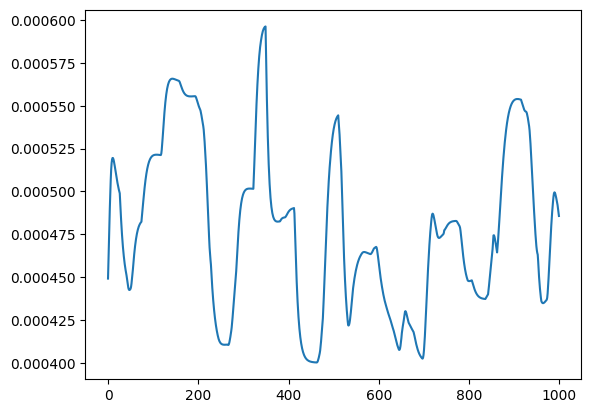

In [62]:
results = do_mpc.data.load_results('./results/MSMPR.pkl')
x = results['simulator']['_aux','L10'][500:]

plt.plot(x)

Convert results to dataframe and save dataframe

In [63]:
# results = do_mpc.data.load_results('./results/876_MSMPR.pkl')
# States
T = results['simulator']['_x','T']
T_j = results['simulator']['_x','T_j']
c = results['simulator']['_x','c']
L10 = results['simulator']['_aux','L10']
mu_0 = results['simulator']['_x','mu'][:,0]
mu_1 = results['simulator']['_x','mu'][:,1]
mu_2 = results['simulator']['_x','mu'][:,2]

# Inputs
T_j_in = results['simulator']['_u','T_j_in']
F_j = results['simulator']['_u','F_j']
F_feed = results['simulator']['_u','F_feed']

# Generate pandas dataframe
# Discard first n samples
n = 500
df = pd.DataFrame({'T_j_in':T_j_in[n:].ravel(), 'F_j':F_j[n:].ravel(), 'F_feed':F_feed[n:].ravel(), 'T':T[n:].ravel(), 'T_j':T_j[n:].ravel(), 'c':c[n:].ravel(),
                    'L10':L10[n:].ravel(), 'mu_0':mu_0[n:], 'mu_1':mu_1[n:], 'mu_2':mu_2[n:]})

# Save dataframe
df.to_pickle('./results/MSMPR1_train_' + str(no_samples-500) + '.pkl')